In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [62]:
# Load the dataset
data = pd.read_parquet(r"C:\Users\HP\Downloads\data.parquet")
data.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [63]:
# Reset index to remove the 'time' index
data.reset_index(drop=True, inplace=True)
data.head()

,banknifty,nifty,tte
0,0.286058,0.199729,27
1,0.285381,0.200433,27
2,0.284233,0.200004,27
3,0.286104,0.199860,27
4,0.285539,0.198951,27


# Understanding the data

In [64]:
# How big is the data
data.shape

(690512, 3)

In [65]:
# how does the data look like
data.sample(5)

,banknifty,nifty,tte
366162,0.170668,0.114941,21
587978,0.232672,0.177625,8
292035,0.179324,0.100229,7
478129,0.211472,0.169915,22
680371,0.231250,0.201330,7


In [66]:
# data type of columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690512 entries, 0 to 690511
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   banknifty  689012 non-null  float64
 1   nifty      688512 non-null  float64
 2   tte        690512 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 13.2 MB


In [67]:
# check the missing values 
data.isna().sum()    

banknifty    1500
nifty        2000
tte             0
dtype: int64

We observe that there are missing values ie. we have to remove or filled these missing values

In [68]:
# Fill missing values using forward fill
data.fillna(method='ffill', inplace=True)
data.isna().sum() 
# missing values are filled 

banknifty    0
nifty        0
tte          0
dtype: int64

In [69]:
# how does the data look mathematically
data.describe()

,banknifty,nifty,tte
count,690512.000000,690512.000000,690512.000000
mean,0.250153,0.179343,15.671884
std,0.057702,0.046142,8.664597
min,0.152732,0.089355,2.000000
25%,0.205307,0.140375,8.000000
50%,0.243977,0.181210,15.000000
75%,0.295293,0.215663,23.000000
max,0.460619,0.306952,31.000000


In [70]:
data.corr()

,banknifty,nifty,tte
banknifty,1.000000,0.896292,-0.069753
nifty,0.896292,1.000000,-0.055790
tte,-0.069753,-0.055790,1.000000


<Axes: xlabel='banknifty', ylabel='Density'>

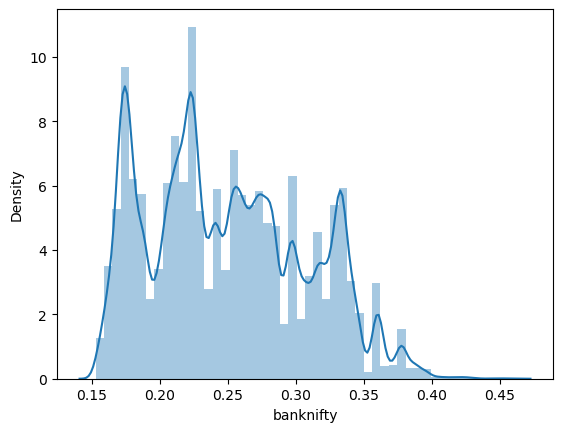

In [71]:
import seaborn as sns
sns.distplot(data['banknifty'])

<Axes: xlabel='nifty', ylabel='Density'>

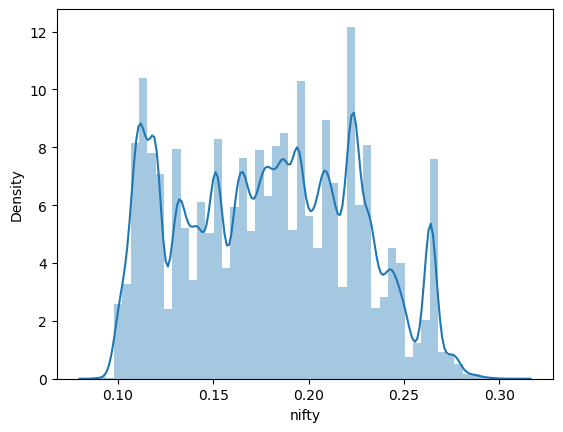

In [72]:
sns.distplot(data['nifty'])

In [73]:
# Calculate the spread between Bank Nifty and Nifty implied volatilities
data['spread'] = data['banknifty'] - data['nifty']
data.head()

,banknifty,nifty,tte,spread
0,0.286058,0.199729,27,0.086329
1,0.285381,0.200433,27,0.084948
2,0.284233,0.200004,27,0.084229
3,0.286104,0.199860,27,0.086244
4,0.285539,0.198951,27,0.086588


In [74]:
# Define trading parameters
entry_threshold = 2
exit_threshold = 0.5

In [75]:
from scipy.stats import zscore

# Calculate z-score of the spread
data['spread_zscore'] = zscore(data['spread'])


In [76]:
# Initialize positions
data['position'] = 0

In [77]:
# Generate signals based on z-score
data.loc[data['spread_zscore'] > entry_threshold, 'position'] = -1  # short spread
data.loc[data['spread_zscore'] < -entry_threshold, 'position'] = 1   # long spread
data.loc[abs(data['spread_zscore']) < exit_threshold, 'position'] = 0  # close position

In [78]:
# Calculate P/L based on the provided formula
data['pnl'] = data['spread'] * data['tte'] ** 0.7

In [79]:
# Calculate cumulative P/L
data['cumulative_pnl'] = data['pnl'].cumsum()

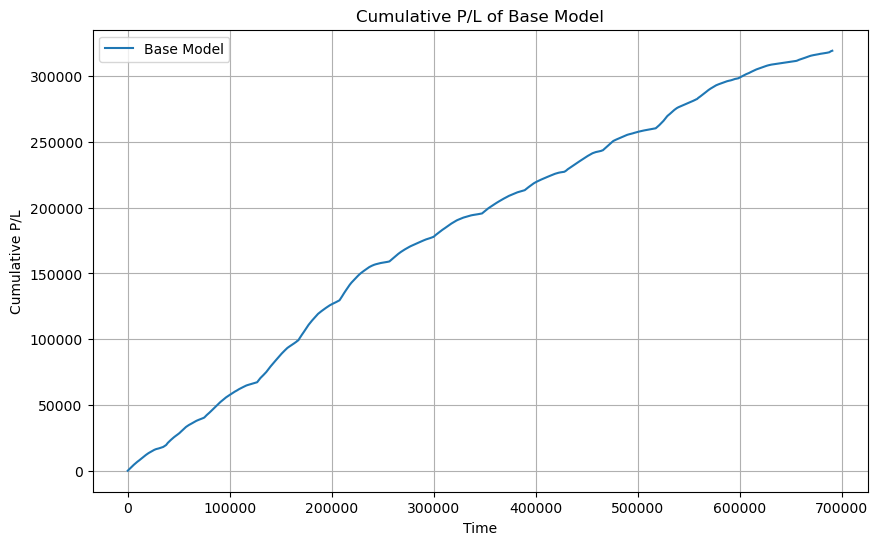

In [80]:
# Plot cumulative P/L of the base model
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['cumulative_pnl'], label='Base Model')
plt.title('Cumulative P/L of Base Model')
plt.xlabel('Time')
plt.ylabel('Cumulative P/L')
plt.grid(True)
plt.legend()
plt.show()

In [81]:
# Calculate statistics of the base model
sharpe_ratio_base = data['pnl'].mean() / data['pnl'].std() * np.sqrt(252)
max_drawdown_base = (data['cumulative_pnl'].cummax() - data['cumulative_pnl']).max()
absolute_pnl_base = data['cumulative_pnl'].iloc[-1]

print('Base Model Statistics:')
print(f'Sharpe Ratio: {sharpe_ratio_base}')
print(f'Max Drawdown: {max_drawdown_base}')
print(f'Absolute P/L: {absolute_pnl_base}')

Base Model Statistics:
Sharpe Ratio: 27.87013122140193
Max Drawdown: 0.0767731094674673
Absolute P/L: 319282.3419875193


# Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define features and target for ML model
X = data[['spread']]
y = data['pnl']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
model_lr = LinearRegression()

# Train the model
model_lr.fit(X_train, y_train)

# Make predictions
predictions_lr = model_lr.predict(X_test)

# Calculate Mean Squared Error
mse_lr = mean_squared_error(y_test, predictions_lr)
print(f'Mean Squared Error: {mse_lr}')
# Calculate statistics of the Linear Regression model
mean_pnl_lr = np.mean(predictions_lr)  # Mean profit and loss
std_pnl_lr = np.std(predictions_lr)    # Standard deviation of profit and loss

if std_pnl_lr != 0:  # Check if standard deviation is not zero
    sharpe_ratio_lr = mean_pnl_lr / std_pnl_lr * np.sqrt(252)
else:
    sharpe_ratio_lr = np.nan  # Set Sharpe Ratio to NaN if standard deviation is zero

max_drawdown_lr = (np.maximum.accumulate(predictions_lr) - predictions_lr).max()  # Max drawdown
absolute_pnl_lr = np.sum(predictions_lr)  # Absolute profit and loss

Mean Squared Error: 0.048172206266452404


In [85]:
print('\nLinear Regression Model Statistics:')
print(f'Sharpe Ratio: {sharpe_ratio_lr}')
print(f'Max Drawdown: {max_drawdown_lr}')
print(f'Absolute P/L: {absolute_pnl_lr}')


Linear Regression Model Statistics:
Sharpe Ratio: 50.23570007262073
Max Drawdown: 1.1828352446261223
Absolute P/L: 63799.03041213052


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# RandomForest Model
Random Forest is a powerful machine learning algorithm that can capture complex relationships between features and target variables.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [38]:
# Load the dataset
data = pd.read_parquet(r"C:\Users\HP\Downloads\data.parquet")
data.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [39]:
# Reset index to remove the 'time' index
data.reset_index(drop=True, inplace=True)
data.head()

,banknifty,nifty,tte
0,0.286058,0.199729,27
1,0.285381,0.200433,27
2,0.284233,0.200004,27
3,0.286104,0.199860,27
4,0.285539,0.198951,27


In [40]:
# check the missing values 
data.isna().sum() 

banknifty    1500
nifty        2000
tte             0
dtype: int64

In [41]:
# Fill missing values using forward fill
data.fillna(method='ffill', inplace=True)
data.isna().sum() 
# missing values are filled 

banknifty    0
nifty        0
tte          0
dtype: int64

In [42]:
# Calculate the spread between Bank Nifty and Nifty implied volatilities
data['spread'] = data['banknifty'] - data['nifty']
data.head()

,banknifty,nifty,tte,spread
0,0.286058,0.199729,27,0.086329
1,0.285381,0.200433,27,0.084948
2,0.284233,0.200004,27,0.084229
3,0.286104,0.199860,27,0.086244
4,0.285539,0.198951,27,0.086588


In [43]:
# Calculate P/L based on the provided formula
data['pnl'] = data['spread'] * data['tte'] ** 0.7
data.head()

,banknifty,nifty,tte,spread,pnl
0,0.286058,0.199729,27,0.086329,0.867184
1,0.285381,0.200433,27,0.084948,0.853317
2,0.284233,0.200004,27,0.084229,0.846089
3,0.286104,0.199860,27,0.086244,0.866325
4,0.285539,0.198951,27,0.086588,0.869786


In [44]:
# Calculate cumulative P/L
data['cumulative_pnl'] = data['pnl'].cumsum()

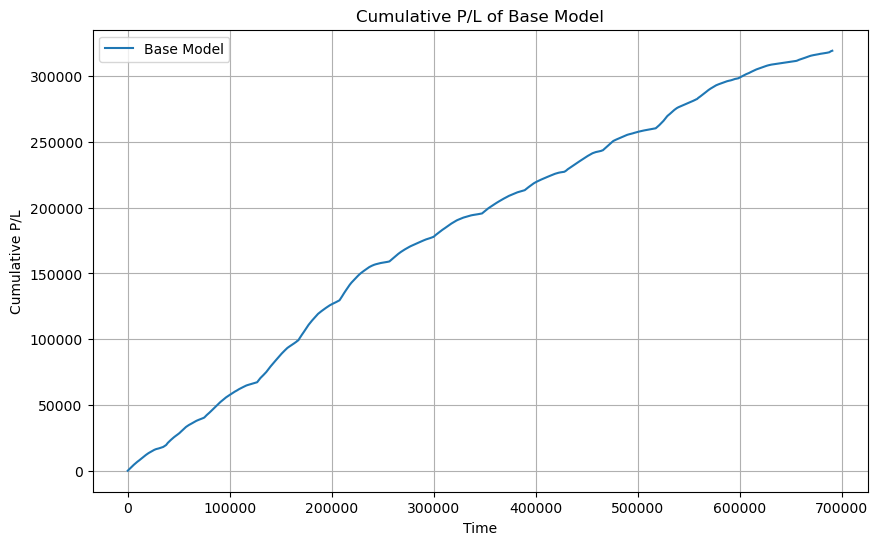

In [45]:
# Plot cumulative P/L of the base model
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['cumulative_pnl'], label='Base Model')
plt.title('Cumulative P/L of Base Model')
plt.xlabel('Time')
plt.ylabel('Cumulative P/L')
plt.grid(True)
plt.legend()
plt.show()

In [46]:
# Define features and target for ML model
X = data[['spread']]
y = data['pnl']

In [47]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [49]:
# Initialize Random Forest Regressor model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [50]:
# Train the model
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [51]:
# Make predictions
predictions_rf = model_rf.predict(X_test)

In [52]:
# Calculate Mean Squared Error
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f'Mean Squared Error: {mse_rf}')

Mean Squared Error: 0.00983401469268318


 a Mean Squared Error of 0.009834 suggests that your model is performing well in terms of prediction accuracy

In [53]:
# Calculate R-squared
r2 = r2_score(y_test, predictions_rf)
print(f'R-squared: {r2}')

R-squared: 0.8584264660427526


an R-squared value of 0.8584264660427526 suggests that your regression model provides a good fit to the data and explains a significant portion of the variability in the profit/loss based on the spread between Bank Nifty and Nifty implied volatilities. 

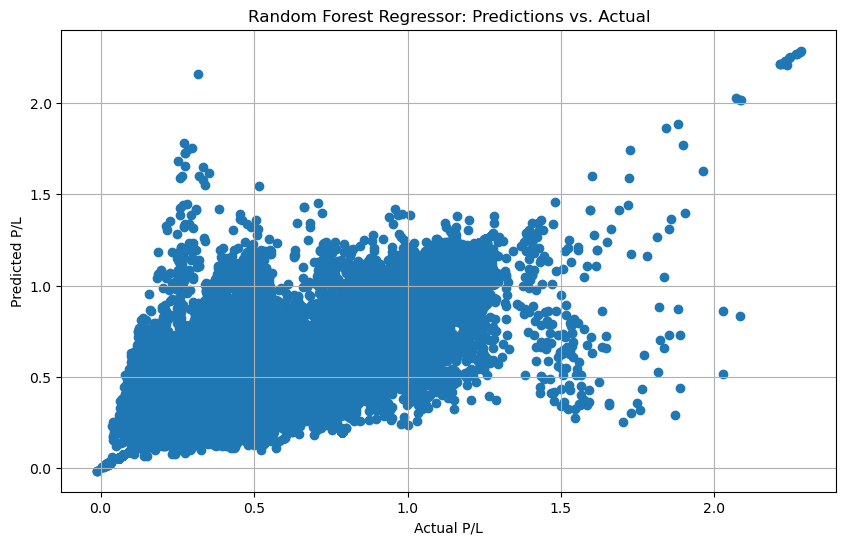

In [54]:
# Plot predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_rf)
plt.xlabel('Actual P/L')
plt.ylabel('Predicted P/L')
plt.title('Random Forest Regressor: Predictions vs. Actual')
plt.grid(True)
plt.show()

In [55]:
# Calculate statistics of the Random Forest model
mean_pnl_rf = np.mean(predictions_rf)  # Mean profit and loss
std_pnl_rf = np.std(predictions_rf)    # Standard deviation of profit and loss

In [56]:
if std_pnl_rf != 0:  # Check if standard deviation is not zero
    sharpe_ratio_rf = mean_pnl_rf / std_pnl_rf * np.sqrt(252)
else:
    sharpe_ratio_rf = np.nan  # Set Sharpe Ratio to NaN if standard deviation is zero


In [57]:
max_drawdown_rf = (np.maximum.accumulate(predictions_rf) - predictions_rf).max()  # Max drawdown
absolute_pnl_rf = np.sum(predictions_rf)  # Absolute profit and loss

print('\nRandom Forest Model Statistics:')
print(f'Sharpe Ratio: {sharpe_ratio_rf}')
print(f'Max Drawdown: {max_drawdown_rf}')
print(f'Absolute P/L: {absolute_pnl_rf}')


Random Forest Model Statistics:
Sharpe Ratio: 28.70460216146521
Max Drawdown: 2.297837347556566
Absolute P/L: 63815.9078274341


these statistics indicate that the Random Forest model is performing well, generating high returns relative to the risk taken (as measured by the Sharpe Ratio), experiencing limited losses during adverse market conditions (Max Drawdown), and generating a substantial profit over the period analyzed (Absolute P/L). 